In [93]:
import numpy as np
import matplotlib.pyplot as plt
import random

helper function to make engine curves, used when needed

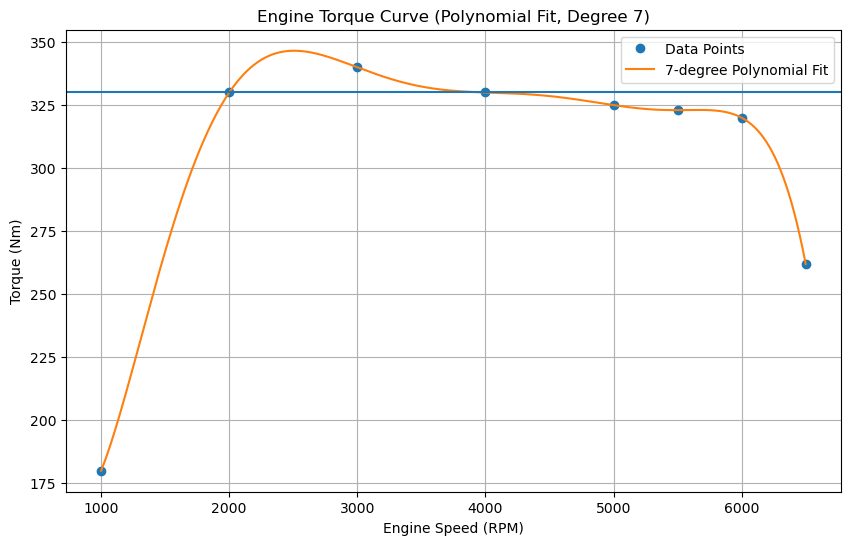

Coefficients of the fitted polynomial:
[-3.26358826e-22  8.59480519e-18 -9.31377946e-14  5.32512626e-10
 -1.70421507e-06  2.95310253e-03 -2.38024502e+00  8.63714286e+02]
coefficient_0: 863.7142857169003,
coefficient_1: -2.380245021651249,
coefficient_2: 0.0029531025252579435,
coefficient_3: -1.7042150673424146e-06,
coefficient_4: 5.325126262632084e-10,
coefficient_5: -9.313779461288092e-14,
coefficient_6: 8.594805194812508e-18,
coefficient_7: -3.263588263591031e-22,


In [94]:
import numpy as np
import matplotlib.pyplot as plt

points = np.array([
    [1000, 180],
    [2000, 330],
    [3000, 340],
    [4000, 330],
    [5000, 325],
    [5500, 323],
    [6000, 320],
    [6500, 262],
])
maxTq = 330
rpm = points[:, 0]
torque = points[:, 1]
degree = 7
coefficients = np.polyfit(rpm, torque, degree)
polynomial = np.poly1d(coefficients)

rpm_smooth = np.linspace(rpm.min(), rpm.max(), 500)
torque_smooth = polynomial(rpm_smooth)

plt.figure(figsize=(10, 6))
plt.plot(rpm, torque, 'o', label="Data Points")
plt.plot(rpm_smooth, torque_smooth, '-', label=f"{degree}-degree Polynomial Fit")
plt.axhline(maxTq)
plt.xlabel("Engine Speed (RPM)")
plt.ylabel("Torque (Nm)")
plt.title(f"Engine Torque Curve (Polynomial Fit, Degree {degree})")
plt.legend()
plt.grid(True)
plt.show()

print("Coefficients of the fitted polynomial:")
print(coefficients)

for i in range(len(coefficients)):
    print(f"coefficient_{i}: {coefficients[len(coefficients)-i-1]},")


# car data

In [95]:
df_coeff = 0.03 # i dont know how much downforce the f1 or the speedtail make so i made it something lower than the 720s
# 0.04455 # mclaren 720S : 200kg at 240kmh/ 67 m/s
# 0.119 for mclaren p1: 600kg at 257 km/h / 71m/s

McLaren Speedtail

In [96]:
weight = 1597 + 100 #kg
rear_weight = 0.58 # %
c_d = 0.35
frontal = 1.98 #m^2
wheel_radius = 0.360
tyre_coeff = 1.5
cm_height = 0.35
wheelbase = 2.730
drive = -1

# gearbox

McLaren speedtail

In [97]:
final_drive = 3.31
gear_1 = 3.98
gear_2 = 2.61
gear_3 = 1.9
gear_4 = 1.48
gear_5 = 1.16
gear_6 = 0.91
gear_7 = 0.69

gear_index = 0
max_gear = 6
gear = [gear_1, gear_2, gear_3, gear_4, gear_5, gear_6, gear_7]

idle_RPM = 1000
shift_delay_coefficient = 1 # larger coefficient -> slower shifting
flywheel_coefficient = 0.8 # lighter flywheel means bigger coefficient

# engine model

McLaren speedtail

In [98]:
torque = lambda N: 0.35*N - 0.00003*N**2 + 70 +92 * np.sin(0.00045*N)
hp = lambda N: torque(N) * N * 0.7376 / 5252

redline = 8000
engine_speed_list = np.linspace(1500,redline,600)

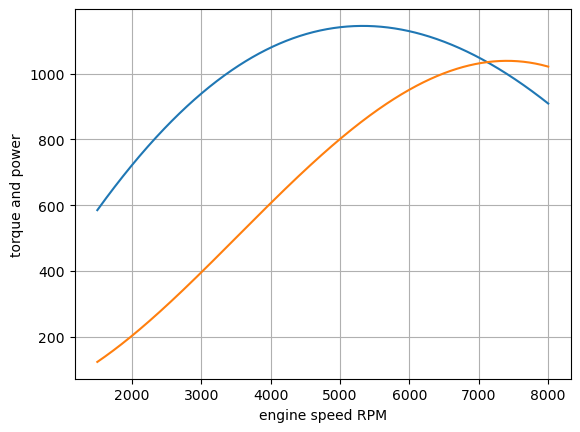

In [99]:
plt.plot(engine_speed_list, torque(engine_speed_list))
plt.plot(engine_speed_list, hp(engine_speed_list))
plt.xlabel("engine speed RPM")
plt.ylabel("torque and power")
plt.grid()
plt.show()

# forces

In [100]:
downforce = lambda speed: df_coeff * speed**2 

vertical_load = lambda speed: weight + downforce(speed)

In [101]:
accel = 0.
# this will save the acceleration in G at any given moment during the simulation

In [102]:
def weight_transfer(drive, accel):
    """returns the percentage of car weight on driving wheels in [0,1]"""
    front_weight = 1 - rear_weight
    if drive == 1: #fwd
        A = 0; B = 1; C = -1
    elif drive == 0: # awd
        A = 1; B = 1; C = 0
    elif drive == -1: # rwd
        A = 1; B = 0; C = 1
    else:
        print("invalid drive type")

    formula = A * rear_weight + B * front_weight + C * (cm_height * accel / wheelbase)
    return formula

In [103]:
torque_at_wheel_axis = lambda N, gear_index: 0.86 * torque(N) * gear[gear_index] * final_drive
def force_at_ground(N, gear_index, speed) :
    '''force passed from the tyre to the ground'''
    max_force = weight_transfer(drive, accel) * weight * 9.81 * tyre_coeff
    return min(torque_at_wheel_axis(N, gear_index) / wheel_radius, max_force)

wheel_aero_drag = lambda speed: 2* 0.00028*speed**2
drag = lambda speed: 0.5 * c_d * frontal * 1.2 * speed**2 + wheel_aero_drag(speed)
roll_resistance = lambda speed:(0.02 + 1.111*1e-7*speed + .24 * 1e-7 * (speed/3.6)**2) * 9.81 * vertical_load(speed) #(0.0136 + 0.4 * 1e-7 * (speed/3.6)**2) * 9.81 * vertical_load(speed) #now using SAE's recommendation # (1e-2 + 5e-7 * speed /3.6 + 2e-7 * speed**2 /3.6**2) * 9.81 * vertical_load(speed)

In [104]:
def f(t,speed,N, gear_index): 
    '''du/dt = f, the derivative of speed in newton's equation. It is the sum of forces divided by mass'''
    return (force_at_ground(N, gear_index,speed) - drag(speed) - roll_resistance(speed))/weight


In [105]:
# find engine speed from vehicle speed
get_RPM = lambda speed, gear_index: speed * 30 * gear[gear_index] * final_drive /(np.pi * wheel_radius)

- start with u = 0, t=0 and 1st gear with N = 3000
- find next u i+1
- from the new u find new engine speed
- use the new engine speed to find the new torque and use that torque for u i+2

# results

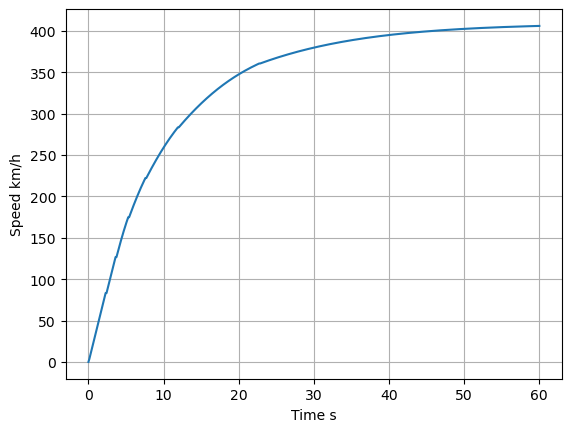

In [106]:
end = 60 #s
max_steps = 500
time = np.linspace(0,end,max_steps) # s
step = end/max_steps

# cache
speed = np.zeros(max_steps) # m/s
accel_list = []
accel_list.append(accel)
speed[0] = 0
N_launch =5000 # launch at N_launch rpm with 0 speed

N = N_launch
N_s = [N]
tire_forces = [force_at_ground(N, gear_index, speed[0])]
torque_at_wheel_list = [torque_at_wheel_axis(N, gear_index)]
crank_torque_list = [torque(N)]
gear_list = [gear_index]

i=1
while i < max_steps:
    #euler
    #speed[i] = speed[i-1] + step*f(time[i-1], speed[i-1],N, gear_index)

    # runge kutta
    k1 = step * f(time[i-1], speed[i-1],N, gear_index)
    k2 = step * f(time[i-1] + 0.5 * step, speed[i-1] + 0.5 * k1, N, gear_index)
    k3 = step * f(time[i-1] + 0.5 * step, speed[i-1] + 0.5 * k2, N, gear_index)
    k4 = step * f(time[i-1] + step, speed[i-1] + k3, N, gear_index)
 
    speed[i] = speed[i-1] + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)

    # acceleration in G
    delta_u = speed[i] - speed[i-1]
    delta_t = step
    accel = delta_u /(delta_t * 9.81) # in G
    accel_list.append(accel)

    # add tire forces and engine RPM to cache
    tire_forces.append(force_at_ground(N, gear_index, speed[i-1]))
    torque_at_wheel_list.append(torque_at_wheel_axis(N, gear_index))
    crank_torque_list.append(torque(N))
    N_s.append(N)

    # find the rpm for the next time step
    N_new = get_RPM(speed[i], gear_index) # use launch rpm until wheel speed asks for more rpm

    if gear_index == 0:
        N = max(N_new, N_launch)
    else:
        N = N_new

    if N > redline :
        if gear_index < max_gear:
            gear_index+=1  # next gear
            
            shift_time = step * shift_delay_coefficient # = 0.12 * 4 = 0.48 s
            # -> means we skip 5 steps

            const = speed[i]
            for j in range(i+1,i+shift_delay_coefficient+1):
                speed[j] = const # maintain constant speed for 5 time steps
                N -= 500 * flywheel_coefficient # rpm drop each step

                # update cache
                N_s.append(max(N, idle_RPM))
                accel_list.append(0)
                tire_forces.append(0)
                torque_at_wheel_list.append(0)
                crank_torque_list.append(torque(N))
                gear_list.append(gear_index)

            i += shift_delay_coefficient # move time to 5 steps ahead to keep solving the differential equation
            # the rpm should match wheel speed through the clutch
            N = get_RPM(speed[i-1], gear_index)
        else:
            N = redline # stay on redline
            
    
    i+=1
    gear_list.append(gear_index)

plt.plot(time, speed*3.6)
plt.xlabel('Time s')
plt.ylabel('Speed km/h')
plt.grid()
plt.show()

In [107]:
speedlist = speed*3.6

# Function to find the index of the closest value in list1
def find_closest_index(target):
    closest_index = None
    min_diff = float('inf')
    for i, value in enumerate(speedlist):
        diff = abs(value - target)
        if diff < min_diff:
            min_diff = diff
            closest_index = i
    return closest_index


def show_time_to(input_speed):
    index = find_closest_index(input_speed)
    value = time[index]
    print(f'0 - {input_speed} kmh = {value}')

show_time_to(100)
show_time_to(160)
show_time_to(180)
show_time_to(200)
show_time_to(240)
show_time_to(300)
show_time_to(320)

print('top speed', max(speedlist))

0 - 100 kmh = 2.885771543086172
0 - 160 kmh = 4.809619238476953
0 - 180 kmh = 5.651302605210421
0 - 200 kmh = 6.492985971943887
0 - 240 kmh = 8.77755511022044
0 - 300 kmh = 13.587174348697394
0 - 320 kmh = 15.871743486973948
top speed 406.16488431707575


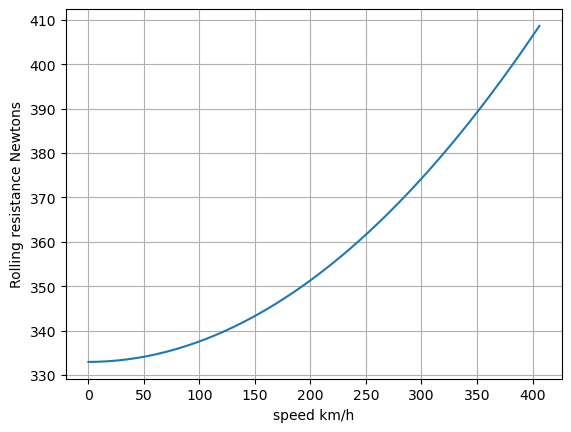

In [108]:
plt.plot(speed*3.6, roll_resistance(speed))
plt.grid()
plt.xlabel("speed km/h")
plt.ylabel("Rolling resistance Newtons")
plt.show()

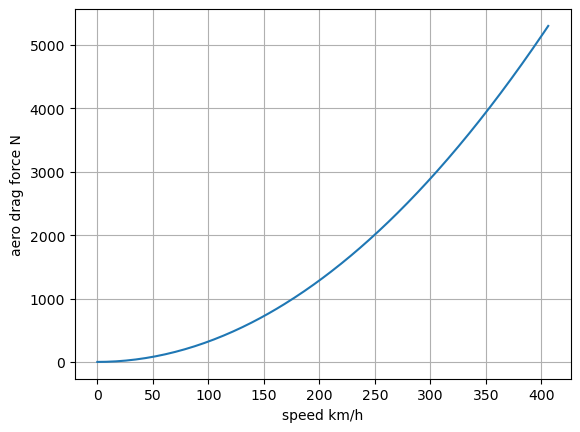

In [109]:
plt.plot(speed*3.6, drag(speed))
plt.grid()
plt.xlabel("speed km/h")
plt.ylabel("aero drag force N")
plt.show()

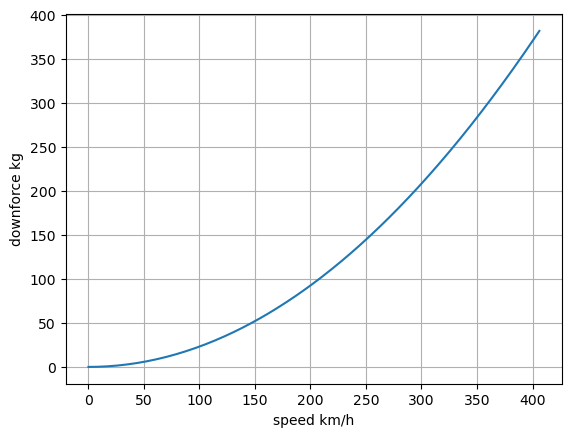

In [110]:
plt.plot(speed*3.6, downforce(speed))
plt.grid()
plt.xlabel("speed km/h")
plt.ylabel("downforce kg")
plt.show()

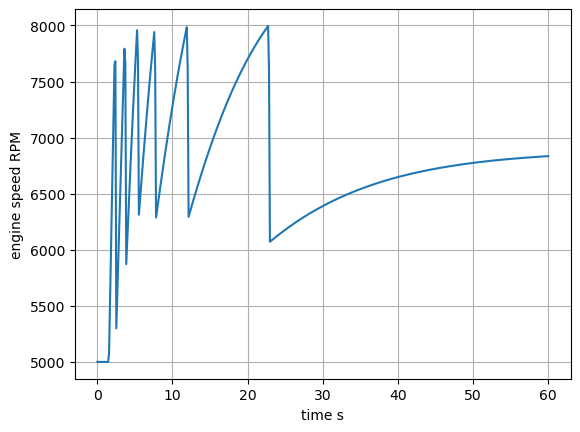

In [111]:
plt.plot(time, N_s)
plt.xlabel("time s")
plt.ylabel("engine speed RPM")
plt.grid()
plt.show()


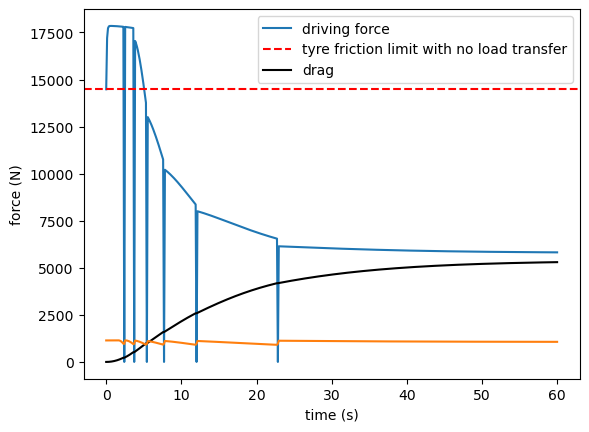

In [112]:
plt.plot(time, tire_forces, label='driving force')
plt.axhline(rear_weight*weight*9.81*tyre_coeff, color='red', linestyle='--', label='tyre friction limit with no load transfer')
plt.plot(time, drag(speed), color='black', label='drag')
plt.plot(time, crank_torque_list)
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("force (N)")
plt.show()

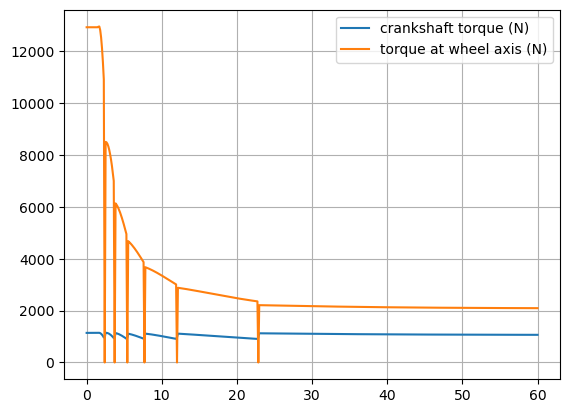

In [113]:
plt.plot(time, crank_torque_list, label="crankshaft torque (N)")
plt.plot(time, torque_at_wheel_list, label="torque at wheel axis (N)")
plt.legend()
plt.grid()
plt.show()

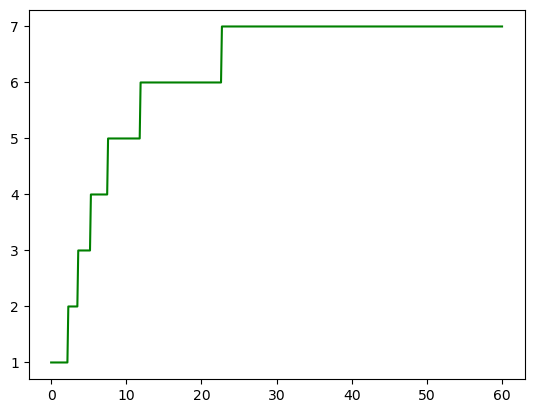

In [114]:
gear_list = [gear+1 for gear in gear_list]
plt.plot(time, gear_list, color='green')
plt.show()

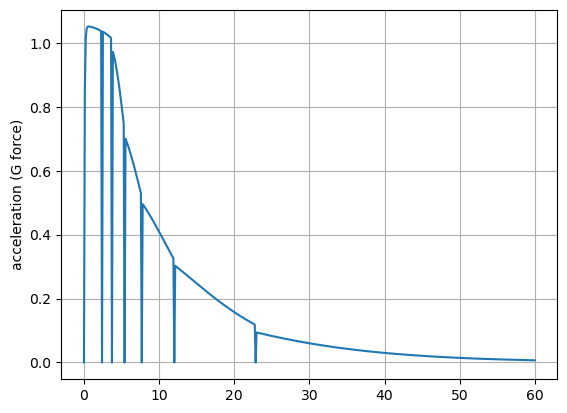

In [115]:
plt.plot(time, accel_list)
plt.grid()
plt.ylabel("acceleration (G force)")
plt.show()